# Film Script Analyzer

## Regression

The process to obtain the best prediction of the imdbRating will be pretty similar to the classification part. Changes will be in the version of the algorithm, regression instead of classification, the performance metric MAE or RMSE and some other detailes, but overall the process is the same.

In [1]:
import pandas as pd 

df = pd.read_csv('data/dfminmax.csv',index_col=0)

Remove instances where imdbRating is N/A.

In [2]:
index = df['imdbRating'].isnull()

train   = df[df.columns[:44]].ix[~index]
target  = df['imdbRating'].ix[~index]

Define **'error'** a little function that will be useful later, will use it to compute MAE and RMSE.

In [3]:
def error(x,y,n=1.):
    samples = float(len(x))
    result  = 0.
    for i, j in zip(x,y):
        result += abs(i-j)**n
    return (result/samples)**(1/n)

Without further due, start by tuning the algorithms to be used, the goal will be to minimize MAE. This process was run serveral times, presented below only the best iteration, start with SVR then RFR.

In [8]:
from sklearn.svm             import SVR
from sklearn.metrics         import mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':['linear','rbf','sigmoid'],'gamma':[0.05,1,2],'C':[100,200,400]}
clf        = SVR()
acc_scorer = make_scorer(mean_absolute_error,greater_is_better=False)
grid_obj   = GridSearchCV(clf,parameters,scoring=acc_scorer)
grid_obj   = grid_obj.fit(train,target)
clf        = grid_obj.best_estimator_

print grid_obj.best_score_
print grid_obj.best_params_

-0.768508991086
{'kernel': 'rbf', 'C': 200, 'gamma': 0.05}


In [9]:
from sklearn.ensemble import RandomForestRegressor as RFR

parameters = {'n_estimators':[125,250,500],'max_depth':[10,15,20]}
clf        = RFR()
grid_obj   = GridSearchCV(clf,parameters,scoring=acc_scorer)
grid_obj   = grid_obj.fit(train,target)
clf        = grid_obj.best_estimator_

print grid_obj.best_score_
print grid_obj.best_params_

-0.801680831893
{'n_estimators': 500, 'max_depth': 15}


In [4]:
from sklearn.feature_selection import SelectFromModel, f_regression, mutual_info_regression, SelectKBest
import numpy                   as np

def splitter(x,splits,n=0):
    L     = len(x)
    split = int(L/splits)
    test  = range(n*split,(n+1)*split)
    train = range(0,test[0])+range(test[-1]+1,L)
    return train, test

def subsetr(model,train,target,n=3):
    side = train.shape[1]
    predictions = pd.DataFrame(data=np.zeros(shape=(side,2)),
                               columns=['f_reg','m_i_reg'],
                               index=range(1,side+1))

    for i in range(side,0,-1):
        clf_f = SelectKBest(f_regression,k=i)
        clf_f.fit(train,target)
        c_l   = list(train.columns[clf_f.get_support(True)])
        df_f  = clf_f.transform(train)

        clf_m = SelectKBest(mutual_info_regression,k=i)
        clf_m.fit(train,target)
        c_m   = list(train.columns[clf_m.get_support(True)])
        df_m  = clf_m.transform(train)

        for j in range(n):
            train_index, test_index         = splitter(target,n,j)
            
            clf                             = model
            clf.fit(df_f[train_index],target[train_index])
            pred                            = clf.predict(df_f[test_index])
            predictions['f_reg'].ix[i]     += error(pred,target[test_index])/n

            clf2                            = model
            clf2.fit(df_m[train_index],target[train_index])
            pred                            = clf2.predict(df_m[test_index])
            predictions['m_i_reg'].ix[i]   += error(pred,target[test_index])/n
    
    return predictions

Check the best features to include.

In [12]:
sub_svr = subsetr(SVR(kernel='rbf',C=200.0,gamma=0.05),train,target,n=3)

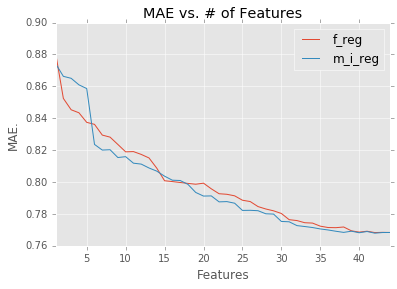

In [13]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

sub_svr.plot()
plt.xlabel('Features')
plt.ylabel('MAE.')
plt.title('MAE vs. # of Features')
plt.show()

In [14]:
print sub_svr.sort_values(by='f_reg',ascending=True).head(1)
print sub_svr.sort_values(by='m_i_reg',ascending=True).head(1)

     f_reg  m_i_reg
42  0.7683  0.76793
     f_reg  m_i_reg
42  0.7683  0.76793


Best MAE performance with m_i_reg and 42 features.

In [ ]:
sub_rfr = subsetr(RFR(n_estimators=500,max_depth=15,random_state=0),train,target,n=3)

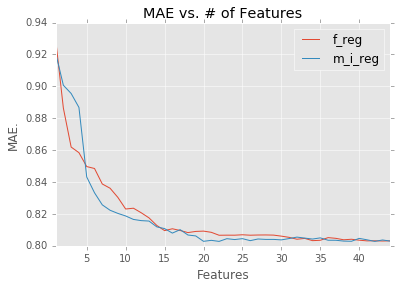

In [23]:
sub_rfr.plot()
plt.xlabel('Features')
plt.ylabel('MAE.')
plt.title('MAE vs. # of Features')
plt.show()

In [24]:
print sub_rfr.sort_values(by='f_reg',ascending=True).head(1)
print sub_rfr.sort_values(by='m_i_reg',ascending=True).head(1)

       f_reg  m_i_reg
43  0.803005  0.80365
       f_reg   m_i_reg
22  0.806617  0.802766


Best MAE performance with m_i_reg and 22 features.

In [9]:
clf    = SelectKBest(mutual_info_regression,k=42)
clf.fit(train,target)
colsvr = train.columns[clf.get_support(True)]

clf    = SelectKBest(mutual_info_regression,k=22)
clf.fit(train,target)
colrfr = train.columns[clf.get_support(True)]

In [10]:
rfr      = RFR(n_estimators=500,max_depth=15,random_state=0)
rfr.fit(train[colrfr],target)
rfr_pred = rfr.predict(train[colrfr])

svr      = SVR(kernel='rbf',C=200.0,gamma=0.05)
svr.fit(train[colsvr],target)
svr_pred = svr.predict(train[colsvr])

In [13]:
print 'SVR MAE: {}'.format(error(svr_pred,target))
print 'RFR MAE: {}'.format(error(rfr_pred,target))

SVR MAE: 0.708712315721
RFR MAE: 0.441183516319


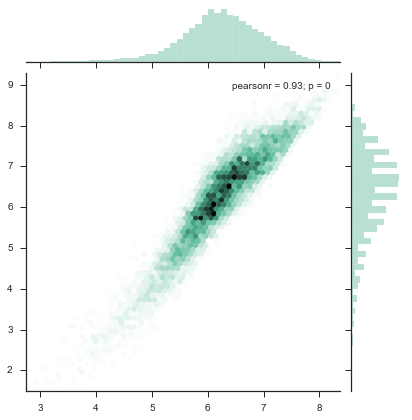

In [12]:
import seaborn   as sns
import matplotlib.pyplot as plt
sns.set(style="ticks")

sns.jointplot(rfr_pred,target.values,kind="hex",color="#4CB391");

Next section: [Recommendation](https://github.com/luisecastro/film_script_analysis/blob/master/09_recommendation.ipynb)